In [179]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import pingouin as pg
from scipy.stats import norm
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")


sns.set(rc={'figure.figsize':(10,6)})

# ЗАДАНИЕ 1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

# Предподготовка данных. Разведочный анализ.

In [180]:
# Считываем данные о времени регистрации
regest_time = pd.read_csv('problem1-reg_data.csv', sep=';')

In [181]:
# Смотрим содержание датафрейма
regest_time.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [182]:
# Количество строк и столбцов
regest_time.shape

(1000000, 2)

In [183]:
# Проверяем данные на пропуски
regest_time.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [184]:
# Проверяем на наличие дубликатов
regest_time.loc[regest_time.duplicated()]

,reg_ts,uid


In [185]:
# Проверяем типы данных
regest_time.dtypes

reg_ts    int64
uid       int64
dtype: object

In [186]:
# Переводим колонку reg_ts в формат даты
regest_time['reg_ts'] = pd.to_datetime(regest_time['reg_ts'], unit='s')

In [187]:
# Создаём новую колонку и помещаем туда дату в формате ГГГГ-ММ-ДД
regest_time['reg_ts_date'] = pd.to_datetime(regest_time['reg_ts'].dt.date)

In [188]:
# Проверяем добавилась ли новая колонка
regest_time.head()

,reg_ts,uid,reg_ts_date
0,1998-11-18 09:43:43,1,1998-11-18
1,1999-07-22 22:38:09,2,1999-07-22
2,2000-01-13 22:27:27,3,2000-01-13
3,2000-05-28 14:19:01,4,2000-05-28
4,2000-09-16 11:21:53,5,2000-09-16


In [189]:
# Проверяем, что даты сконвертировались в нужный формат
regest_time.dtypes

reg_ts         datetime64[ns]
uid                     int64
reg_ts_date    datetime64[ns]
dtype: object

In [190]:
# Сгруппируем данные и посмотрим даты регистрации (когорты), где всего 1 пользователь
regest_time.groupby('reg_ts_date').uid.nunique().to_frame().query('uid == 1').reset_index()

,reg_ts_date,uid
0,1998-11-18,1
1,1999-07-22,1
2,2000-01-13,1
3,2000-05-28,1
4,2000-09-16,1
...,...,...
836,2009-05-30,1
837,2009-06-06,1
838,2009-06-14,1
839,2009-06-23,1


В данных 841 когорта с единственным пользователем. Такие когорты при принятии бизнес решений, основанных на когортном анализе, не целесообразно учитывать, т.к. они будут давать завышенный retention по сравнению с остальными когортами. Если пользователь из данной когорты зайдёт в игру в другой день, то retention будет равен 100%. Для примера, в когорте, где было зарегистрировано 100 человек и на какой-нибудь последующий день в игру зайдёт 30 человек, то retention будет равен 30%. При принятии маркетинговых решений делать рассылки или добавлять новые функции, основываясь на данных когорты с 1 пользователем, будет нецелесообразно. В данном задании нужно написать функцию по расчёту retention по дням от даты регистрации, поэтому такие когорты оставим. Однако, при принятии решений, необходимо учитывать данный момент.

In [191]:
# Cоздаём колонку с наименованием года регистрации.
regest_time['reg_ts_year'] = regest_time['reg_ts'].dt.year

<Axes: xlabel='reg_ts_year'>

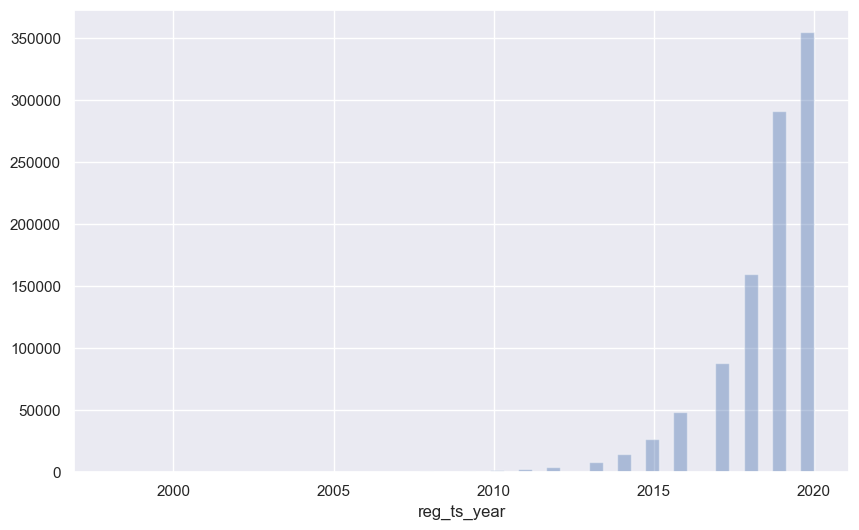

In [192]:
# Посмотрим распределение количества регистраций по годам
sns.distplot(regest_time['reg_ts_year'], kde=False)

In [193]:
# Сгруппиреум данные по годам и посчитаем разницу в количестве регистраций по годам
df = regest_time.groupby('reg_ts_year').reg_ts.count().reset_index()
df['reg_dif'] = df['reg_ts'].diff()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 [Text(0, 0, '1998'),
  Text(1, 0, '1999'),
  Text(2, 0, '2000'),
  Text(3, 0, '2001'),
  Text(4, 0, '2002'),
  Text(5, 0, '2003'),
  Text(6, 0, '2004'),
  Text(7, 0, '2005'),
  Text(8, 0, '2006'),
  Text(9, 0, '2007'),
  Text(10, 0, '2008'),
  Text(11, 0, '2009'),
  Text(12, 0, '2010'),
  Text(13, 0, '2011'),
  Text(14, 0, '2012'),
  Text(15, 0, '2013'),
  Text(16, 0, '2014'),
  Text(17, 0, '2015'),
  Text(18, 0, '2016'),
  Text(19, 0, '2017'),
  Text(20, 0, '2018'),
  Text(21, 0, '2019'),
  Text(22, 0, '2020')])

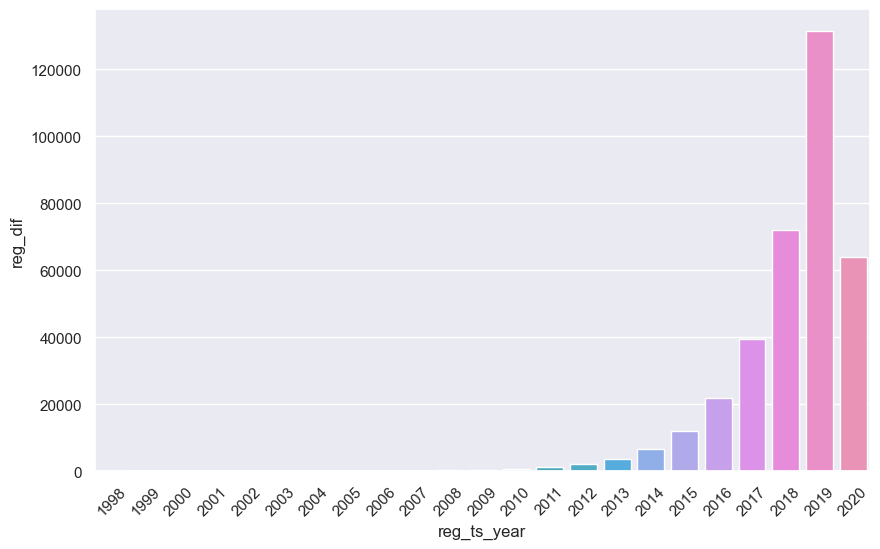

In [194]:
# Визуализируем полученные данные. 
# По графику видно, что больше всего регистраций увеличилось в 2019 году по сравнению с 2018.
sns.barplot(data=df, x='reg_ts_year', y='reg_dif')
plt.xticks(rotation=45)

In [195]:
# Считываем данные о о времени захода пользователей в игру
visit_time = pd.read_csv('problem1-auth_data.csv', sep=';')

In [196]:
visit_time.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [197]:
# Количество строк и столбцов
visit_time.shape

(9601013, 2)

In [198]:
# Проверяем на наличие дубликатов
visit_time.loc[visit_time.duplicated()]

,auth_ts,uid


In [199]:
# Проверяем пропуски в данных
visit_time.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [200]:
# Проверяем типы данных
visit_time.dtypes

auth_ts    int64
uid        int64
dtype: object

In [201]:
# Конвертируем колонку auth_ts в формат даты
visit_time['auth_ts'] = pd.to_datetime(visit_time['auth_ts'], unit='s')

In [202]:
# Создаём новую колонку и помещаем туда сконвертированную дату
visit_time['auth_ts_date'] = pd.to_datetime(visit_time['auth_ts'].dt.date)

In [203]:
# Проверяем, что даты сконвертировались в нужный формат
visit_time.dtypes

auth_ts         datetime64[ns]
uid                      int64
auth_ts_date    datetime64[ns]
dtype: object

In [204]:
visit_time.head()

,auth_ts,uid,auth_ts_date
0,1998-11-18 09:43:43,1,1998-11-18
1,1999-07-22 22:38:09,2,1999-07-22
2,1999-07-25 16:46:46,2,1999-07-25
3,1999-07-31 03:50:15,2,1999-07-31
4,1999-08-05 17:49:39,2,1999-08-05


In [205]:
# Объединим таблицы с данными о регистрации и визитах
reg_visit = visit_time.merge(regest_time, how='left', on='uid')

In [206]:
reg_visit.head()

,auth_ts,uid,auth_ts_date,reg_ts,reg_ts_date,reg_ts_year
0,1998-11-18 09:43:43,1,1998-11-18,1998-11-18 09:43:43,1998-11-18,1998
1,1999-07-22 22:38:09,2,1999-07-22,1999-07-22 22:38:09,1999-07-22,1999
2,1999-07-25 16:46:46,2,1999-07-25,1999-07-22 22:38:09,1999-07-22,1999
3,1999-07-31 03:50:15,2,1999-07-31,1999-07-22 22:38:09,1999-07-22,1999
4,1999-08-05 17:49:39,2,1999-08-05,1999-07-22 22:38:09,1999-07-22,1999


In [207]:
# Удаляем ненужные колонки
reg_visit.drop(columns=['auth_ts', 'reg_ts', 'reg_ts_year'], inplace=True)

In [208]:
# Посчитаем разницу между датой регистрации и датой захода пользователей в игру
reg_visit['days_from_reg'] = (reg_visit['auth_ts_date'] - reg_visit['reg_ts_date']).apply(lambda x: x.days)

<Axes: >

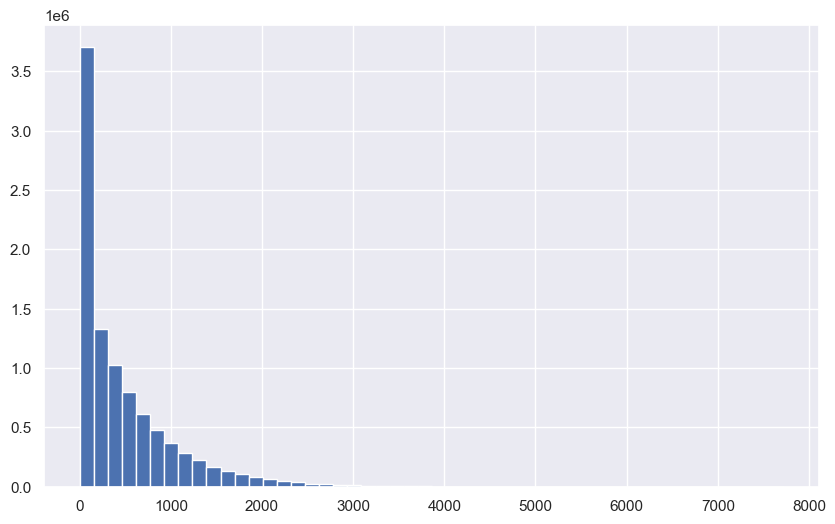

In [209]:
# Посмотрим на распределение числа дней между датой регистрации и датами захода
# Видим, что больше всего посещений в первые дни.
reg_visit.days_from_reg.hist(bins=50)

# Retention игроков

In [210]:
# Напишем функцию для расчёта Retention
def ret(data):
    # Сгруппируем данные по датам регитрации и захода и посчитаем уникальных пользователей.
    data_1 = data.groupby(['reg_ts_date', 'days_from_reg'])['uid'].nunique().reset_index()
    
    # Развернем датафрейм.
    data_p = data_1.pivot(index='reg_ts_date', columns='days_from_reg', values='uid')
    
    # Посчитаем retention
    retention = round(data_p.div(data_p.iloc[:,0], axis = 0).mul(100), 2).fillna(0)
    
    return retention 

In [211]:
# Проверяем работу функции 
ret(reg_visit)

days_from_reg,0,1,2,3,4,5,6,7,8,9,...,7701,7704,7706,7709,7712,7716,7720,7721,7727,7729
reg_ts_date,,,,,,,,,,,,,,,,,,,,,
1998-11-18,100.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999-07-22,100.0,0.00,0.00,100.00,0.00,0.0,0.0,0.0,0.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2000-01-13,100.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-05-28,100.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-09-16,100.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-19,100.0,1.84,3.55,4.71,3.49,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-20,100.0,2.44,4.34,2.38,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-21,100.0,1.89,2.99,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [212]:
# Проверяем работу функции на части (сэмпле) данных
ret(reg_visit.sample(1000))

days_from_reg,0,2,3,4,5,6,7,8,9,10,...,2611,2637,2646,2657,2797,2842,2858,3012,3120,4701
reg_ts_date,,,,,,,,,,,,,,,,,,,,,
2006-07-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-08-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-10-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-09-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-07-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-30,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-04,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-12,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [213]:
# Посмотрим на когорты с максимальным retention
def max_day_ret(data, *args):
    # Посчитаем разницу между датой регистрации и датой захода пользователей в игру
    data['days_from_reg'] = (data['auth_ts_date'] - data['reg_ts_date']).apply(lambda x: x.days)
    
    # Сгруппируем данные по датам регитрации и захода и посчитаем уникальных пользователей.
    data_1 = data.groupby(['reg_ts_date', 'days_from_reg'])['uid'].nunique().reset_index()
    
    # Развернем датафрейм.
    data_p = data_1.pivot(index='reg_ts_date', columns='days_from_reg', values='uid')
    
    # Посчитаем retention
    retention = round(data_p.div(data_p.iloc[:,0], axis=0).mul(100), 2).fillna(0)
    
    # Выведем когорты с максимальным retention на любой день
    day_retention = retention.loc[:,[*args]].idxmax().to_frame().reset_index() \
                         .rename(columns={'days_from_reg':'day_retention', 0:'cohort'})
    
    
    return day_retention 

In [214]:
# Когорты с максимальным Retention это лояльные пользователи (игроки). 
# Для данных когорт можно сделать рассылку со спец.условиями (привести друга и получить "повышение" в игре, доп.функции и т.д.)
# Также можно посмотреть какие были фичи в момент установок игры у когорт с максимальным retention.
# Можно составить портрет данных когорт, проанализировать, что именно так долго помогает удерживать их в игре.
max_day_ret(reg_visit, 7, 14, 30, 60, 90, 180)

,day_retention,cohort
0,7,2002-07-16
1,14,1999-07-22
2,30,2004-02-20
3,60,1999-07-22
4,90,2006-01-26
5,180,1999-07-22


Очень важно оценивать не только возвращаемость на 1, 7, 14 день, но и долгосрочный Retention (от 30 дня и позже), именно от него зависит популярность и монетизация игр. В 1 день пользователь сможет получить первое представление об игре. Через 7 дней пользователь уже сможет разобраться в особенностях игры и оценить насколько она ему интересна. Если пользователь остался на 30 день и дольше, то это может говорить о том, что игра его вовлекла. Если игра не смогла заинтересовать пользователя, вряд ли он останется на 30 день и дольше. Если кривая Retention выходит на плато, то это значит, что происходит переход новых пользователей в постоянных игроков. А, это, в свою очередь даёт основание для хорошей монетизации. В игровых продуктах с низким долгосрочным Retention монетизационный потенциал ограничен, поскольку разработчики могут добавить только ограниченное количество функций в первые 30 дней. Добавление новых функций для постоянных игроков даёт больший прирост доходов. Привлечение новых пользователей тоже важно, однако их влияние на доходы можно будет оценить спустя определённое количество времени.

# Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. 
Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. 
При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? 
Какие метрики стоит проанализировать для принятия правильного решения и как?

# Предподготовка данных. Разведочный анализ

In [215]:
# Считываем данные 
res_test = pd.read_csv('Проект_1_Задание_2.csv', sep=';')

In [216]:
# Смотрим содержание датафрейма
res_test.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [217]:
# Проверяем количество строк и столбцов
res_test.shape

(404770, 3)

In [218]:
# Проверяем типы данных
res_test.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [219]:
# В колонке testgroup указан тип object, чтобы не потерять данные при анализе, сделаем явное преобразование к типу string
res_test['testgroup'] = res_test['testgroup'].astype('str')

In [220]:
# Проверяем данные на пропуски
res_test.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

<Axes: xlabel='testgroup', ylabel='revenue'>

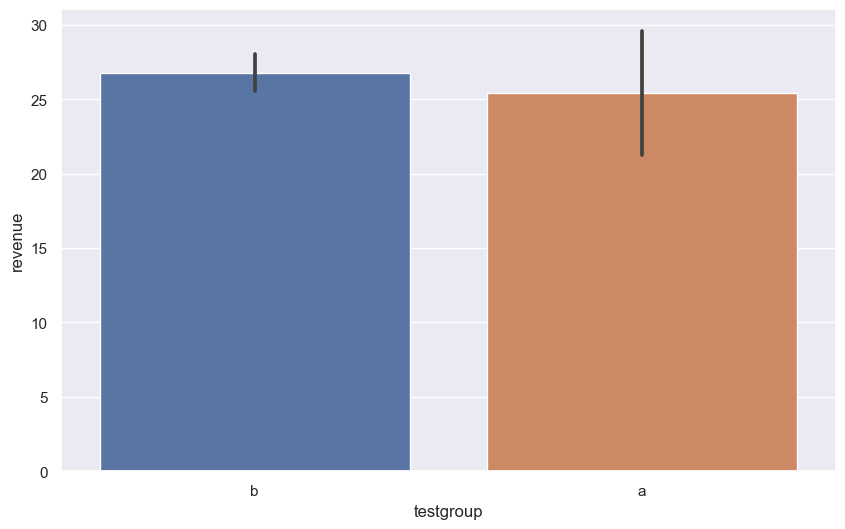

In [221]:
# Посмотрим на соотношение пользователей в группах а и b
sns.barplot(data=res_test, x="testgroup", y="revenue")

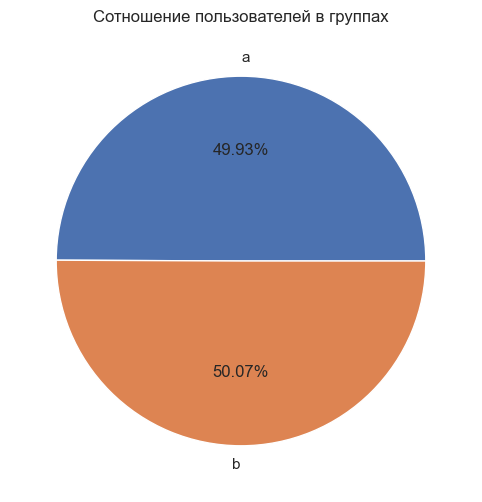

In [222]:
# То же самое с помощью пай чарта
plt.pie(res_test.groupby('testgroup').size(), labels=['a', 'b'], autopct='%.2f%%')
plt.title('Сотношение пользователей в группах')
plt.show()

In [223]:
# Создадим колонку, в которой будет указано в какой группе относится пользователь - к платящей/не платящей
res_test['pay'] = res_test.revenue.apply(lambda x: 'pay' if x > 0 else 'not_pay')

In [224]:
# Проверяем, что функция сработала и у нас добавился новый столбец
res_test.head()

,user_id,revenue,testgroup,pay
0,1,0,b,not_pay
1,2,0,a,not_pay
2,3,0,a,not_pay
3,4,0,b,not_pay
4,5,0,b,not_pay


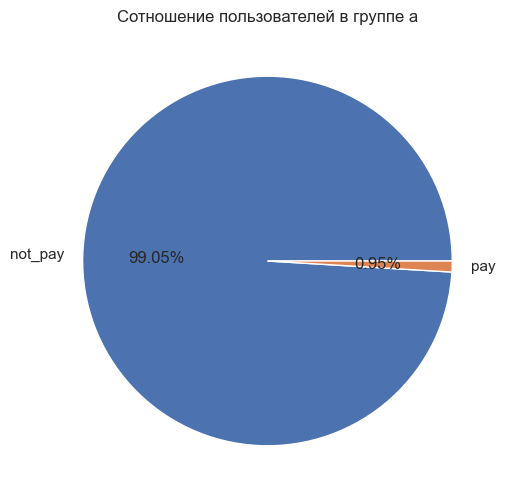

In [225]:
# Посмотрим на соотношение платящих/не плaтящих пользователей в группе а 
plt.pie(res_test.query('testgroup == "a"').groupby('pay').size(), labels=['not_pay', 'pay'], autopct='%.2f%%')
plt.title('Сотношение пользователей в группе а')
plt.show()

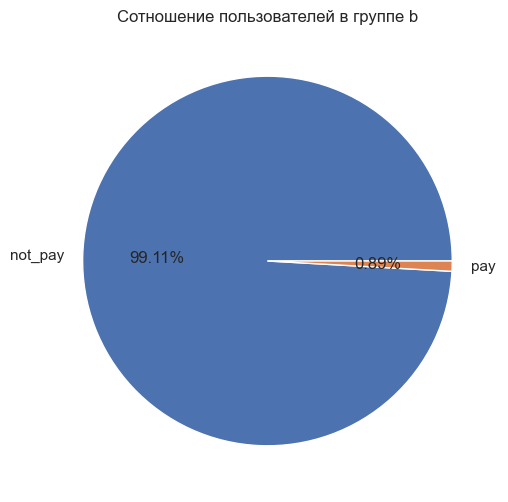

In [226]:
# Посмотрим на соотношение платящих/не плaтящих пользователей в группе b 
plt.pie(res_test.query('testgroup == "b"').groupby('pay').size(), labels=['not_pay', 'pay'], autopct='%.2f%%')
plt.title('Сотношение пользователей в группе b')
plt.show()

In [227]:
# Отфильтруем тех, кто относится к платящим пользователям в группе а
pay_a = res_test.query('pay == "pay" & testgroup == "a"')

In [228]:
# Посмотрим количество платящих пользователей в группе а
pay_a.shape

(1928, 4)

In [229]:
# Отфильтруем тех, кто относится к платящим пользователям в группе b
pay_b = res_test.query('pay == "pay" & testgroup == "b"')

In [230]:
# Посмотрим количество платящих пользователей в группе b
pay_b.shape

(1805, 4)

In [231]:
# В задании указано, что в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.
# Значит контрольная группа в колонке testgroup обозначена буквой а, тестовая буквой b.
# В колонке testgroup переименуем группы а и b в контрольную и тестовую
res_test['testgroup'] = res_test.testgroup.apply(lambda x: 'test' if x == 'b' else 'control')

In [232]:
res_test.head()

,user_id,revenue,testgroup,pay
0,1,0,test,not_pay
1,2,0,control,not_pay
2,3,0,control,not_pay
3,4,0,test,not_pay
4,5,0,test,not_pay


In [233]:
# Рассчитаем такие метрики как ARPU и ARPPU
ARPU_control = res_test.query('testgroup == "control"').revenue.sum() / res_test.query('testgroup == "control"').shape[0]
ARPU_test = res_test.query('testgroup == "test"').revenue.sum() / res_test.query('testgroup == "test"').shape[0]
ARPPU_control = (res_test.query('testgroup == "control"').revenue.sum() 
                 / res_test.query('testgroup == "control" and pay == "pay"').shape[0])
ARPPU_test = (res_test.query('testgroup == "test"').revenue.sum() 
                 / res_test.query('testgroup == "test" and pay == "pay"').shape[0])

In [234]:
# ARPU контрольной и тестовой групп
np.round([ARPU_control, ARPU_test],2)

array([25.41, 26.75])

In [235]:
# ARPPU контрольной и тестовой групп
np.round([ARPPU_control, ARPPU_test],2)

array([2664.  , 3003.66])

<Axes: xlabel='revenue'>

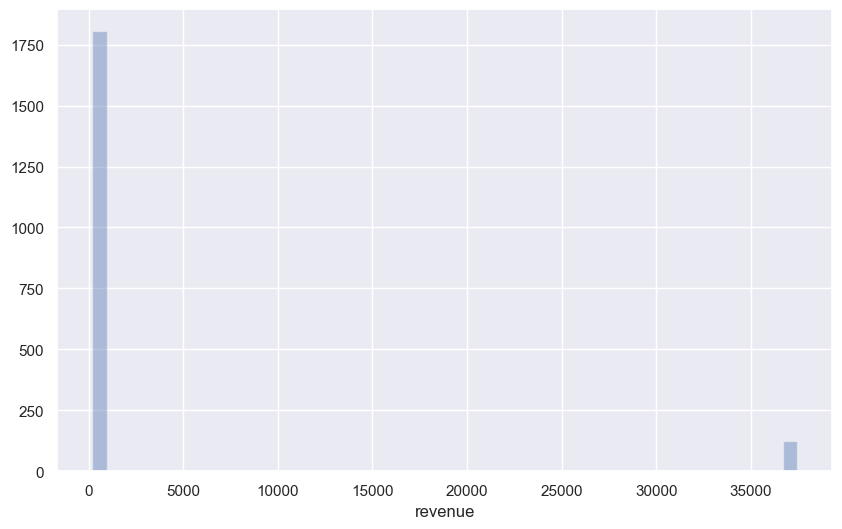

In [236]:
# Посмотрим на распределения частот дохода от платящих пользователей в контрольной группе
sns.distplot(res_test.query('testgroup == "control" and pay == "pay"')['revenue'], kde=False)

In [237]:
# В контрольной группе есть группа выбросов. Также можно посмотреть на описательные статистики колонки revenue. 
res_test.query('testgroup == "control" and pay == "pay"').revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [238]:
# Отфильтруем группу значений меньше 35000 и посмотрим их количество
res_test.query('testgroup == "control" and pay == "pay"').query('revenue < 35000').shape

(1805, 4)

<Axes: xlabel='revenue'>

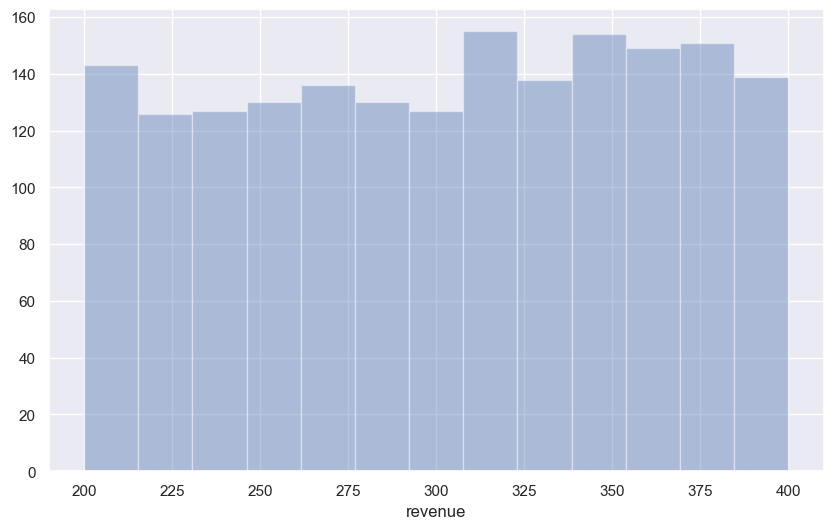

In [239]:
sns.distplot(res_test.query('testgroup == "control" and pay == "pay"').query('revenue < 35000').revenue, kde=False)

In [240]:
# Описательные статистики
res_test.query('testgroup == "control" and pay == "pay"').query('revenue < 35000').revenue.describe()

count    1805.000000
mean      302.458172
std        57.914246
min       200.000000
25%       254.000000
50%       305.000000
75%       352.000000
max       400.000000
Name: revenue, dtype: float64

In [241]:
# Отфильтруем группу значений больше 400 и посмотрим их количество
res_test.query('testgroup == "control" and pay == "pay"').query('revenue > 400').shape

(123, 4)

<Axes: xlabel='revenue'>

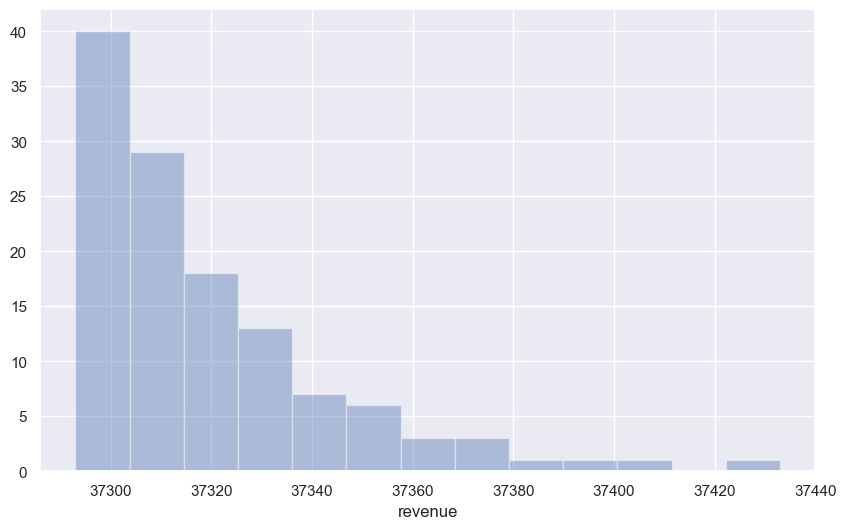

In [242]:
sns.distplot(res_test.query('testgroup == "control" and pay == "pay"').query('revenue > 400').revenue, kde=False)

In [243]:
# Описательные статистики
res_test.query('testgroup == "control" and pay == "pay"').query('revenue > 400').revenue.describe()

count      123.000000
mean     37319.121951
std         25.442183
min      37293.000000
25%      37301.000000
50%      37311.000000
75%      37329.000000
max      37433.000000
Name: revenue, dtype: float64

<Axes: xlabel='revenue'>

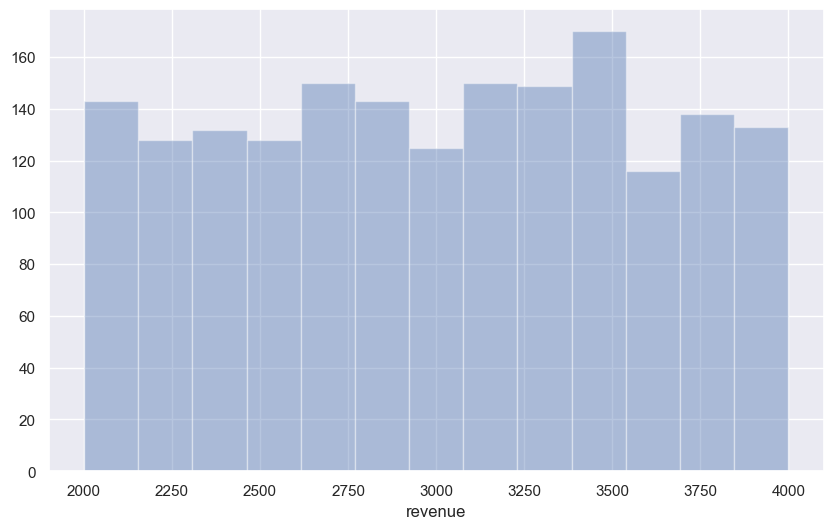

In [244]:
# Посмотрим на распределения частот дохода от платящих пользователей в тестовой группе
sns.distplot(res_test.query('testgroup == "test" and pay == "pay"')['revenue'], kde=False)

Выводы:
1. Распределение пользователей между группами составило: 202103 для контрольной, 202667 для тестовой. В тестовой группе на 1% больше пользователей, чем в контрольной.
2. Распределение платящих пользователей между группами составило: 1928 для контрольной, 1805 для тестовой. В контрольной группе платящих пользователей 0.95% к общему числу группы, в тестовой 0.89% платящих.
3. ARPU для котрольной группы 25.41, для тестовой 26.75.
4. ARPPU для котрольной группы 2664.00, для тестовой 3003.66.
5. В контрольной группе имеется группа выбросов (123 пользователя). Возможно, это ещё одна группа с другими акционными условиями.
6. Визуально, распределения в группах отличаются от нормальных. При обработке результатов эксперимента, нужно проверить 
распределение на нормальность и использовать соответствующий статистический критерий. Для нормального распределения - t-критерий Стьюдента, для ненормального распределения - U-критерий Манна-Утни.

# Обработка результатов эксперимента

У нас две группы, при проверке статистической значимости используется t критерий Стьюдента.
Однако, данный критерий подходит для нормального распределения.

In [245]:
# Проведём проверку распределений на нормальность. Так как у нас больше 5000 наблюдений,используем normaltest.
# Метод Шапиро-Уилка становится чувствительным для выборки больше 5000. 
pg.normality(data=res_test, dv='revenue', group='testgroup', method='normaltest')

,W,pval,normal
testgroup,,,
test,326622.395409,0.0,False
control,585152.731273,0.0,False


In [246]:
# Для платящих пользователей можно использовать метод Шапиро-Уилка
pg.normality(data=res_test.query('pay == "pay"'), dv='revenue', group='testgroup')

,W,pval,normal
testgroup,,,
control,0.266792,0.000000e+00,False
test,0.958313,2.492921e-22,False


In [247]:
# Для платящих пользователей с использованием normaltest
pg.normality(data=res_test.query('pay == "pay"'), dv='revenue', group='testgroup', method='normaltest')

,W,pval,normal
testgroup,,,
control,1394.945784,1.234161e-303,False
test,1068.860008,7.943249e-233,False


<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

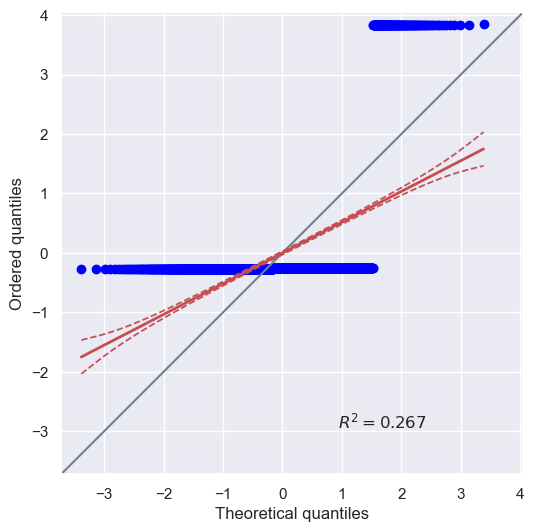

In [248]:
# Cоответствие распределения нормальности также можно посмотреть на графиках qq-plot 
# Для контрольной группы
pg.qqplot(res_test.query('testgroup == "control" and pay == "pay"')['revenue'])

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

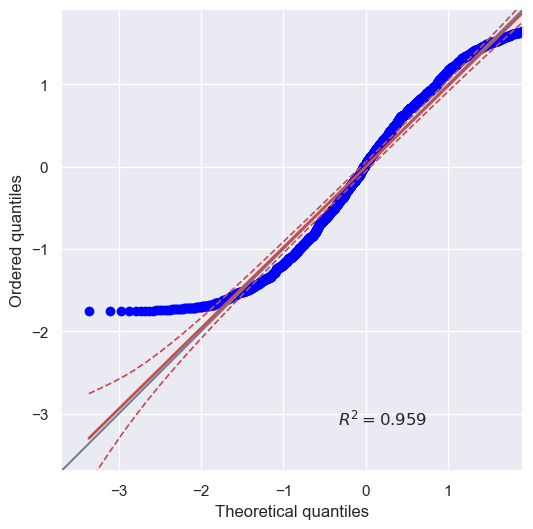

In [249]:
# Для тестовой группы
pg.qqplot(res_test.query('testgroup == "test" and pay == "pay"')['revenue'])

In [250]:
# В случае ненормального распределения используем непараметрический аналог t-теста U-критерий Манна-Уитни.
# Для платящих пользователей 
ss.mannwhitneyu(x=res_test.query('testgroup == "test" and pay == "pay"')['revenue'], y=res_test.query('testgroup == "control" and pay == "pay"')['revenue'])

MannwhitneyuResult(statistic=3258025.0, pvalue=0.0)

In [251]:
# Для всех пользователей (без разделения на платящх и не платящих)
ss.mannwhitneyu(x=res_test.query('testgroup == "test"')['revenue'], y=res_test.query('testgroup == "control"')['revenue'])

MannwhitneyuResult(statistic=20468349325.0, pvalue=0.06269701316074398)

In [252]:
# P-value для платящих пользователей равен 0, а для всех пользователей p-value равен 0.06.
# Для всех пользователей (без разделения на платящих и не платящих) не обнаружено статистически значимых различий.
# Для платящих пользователей обнаружены статистически значимые различия. 
# Так как различные акционные предложения нацелены на увеличение дохода с пользователей, будем принимать решение по платящим пользователям.
# Акционные предложения в тестовой группе b можно считать статистически значимо лучше.

In [253]:
# Посчитаем методом бутстрэпа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.median(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.median(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [254]:
np.random.seed(5)
n = 1000

sample_1 = np.random.exponential(scale=1/0.001, size=n)
sample_2 = np.random.exponential(scale=1/0.001, size=n)

df = pd.DataFrame({
    "sample_1": sample_1,
    "sample_2": sample_2
})

  0%|          | 0/1000 [00:00<?, ?it/s]

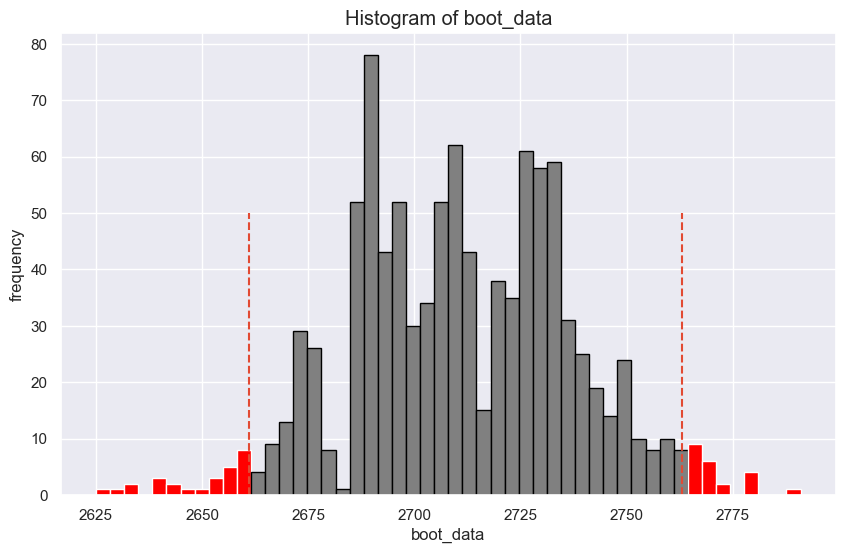

In [255]:
booted_data = get_bootstrap(res_test.query('testgroup == "test" and pay == "pay"')['revenue'], res_test.query('testgroup == "control" and pay == "pay"')['revenue']) 

In [256]:
booted_data["p_value"] 

0.0

Выводы:
1. Распределения в контрольной и тестовой группе не являются нормальными. Использовались методы: Шапиро-Уилка, нормалтест, также построены графики qq-plot. Все методы показали одинаковый результат (отсутствие нормального распределения).
2. Для проверки статистической значимости результатов использовался непараметрический аналог t-теста U-критерий Манна-Уитни и бутстрэп.
3. P-value для обоих методов оказался равен 0, что позволило нам отвергнуть нулевую гипотезу об отстутствии разницы в тратах пользователей в группах с разными акционными условиями. Мы получили статистически значимые различия. 
5. Доход в тестовой группе b платящих пользователей статистически значимо больше, чем в контрольной группе а.

# Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. 
В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. 
Для получения награды требуется пройти ряд уровней за определенное время. 
С помощью каких метрик можно оценить результаты последнего прошедшего события?

1. Процент заинтересованныx в событии пользователей IntrestUserEvent 
IUE = (Количество пользователей, принявших участие в событии / Количество пользователей DAU) * 100%

2. DisIntrestUserEvent (DIUE) - Процент не заинтересованныx в событии пользователей. DIUE = 100% - IUE

3. WU (Win_User) = Количество пользователей, прошедших до конца события / Количество пользователей, принявших участие в событии. 
C помощью данной метрики можно оценить сложность прохождения игры. Если игра очень сложная, то, скорее всего, интерес участвовать в событии, быстро угаснет. Если игра будет слишком лёгкой, заинтересованность участия скорее вcего, тоже быстро пропадёт.

4. Среднее время прохождения события MeanTimeEvent (MTE) пользователей, принявших участие.
MTE = Общее время прохождения события для пользователей / Количество пользователей, принявших участие в событии.

5. Среднее время прохождения n-го уровня MeanTimeEventLevel (MTELn). 
MTELn = Общее время прохождения n-ного уровня для пользователей / Количество пользователей, прошедших n-ный уровень. Так можно оценить сложность конкретного уровня и в дальнейшем произвести корректировку его сложности.

6. CR коэффициент конверсии, c его помощью можно оценить с какого уровня больше всего уходит пользователей.
СR = (Число пользователей, прошедших n-ный уровень / Число пользователей, прошедших (n-1)-ый уровень)* 100%. С помощью данной метрики также можно выявить сложность уровней.

7. ARPU Доход на пользователя, принявшего участие в событии.
ARPU = Доход от всех пользователей, принявших участие в событии / Количество пользователей, принявших участие в событии.

8. ARPPU Доход на платящего пользователя, принявшего участие в событии.
ARPPU = Доход от всех пользователей, принявших участие в событии / Количество платящих пользователей, принявших участие в событии.

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

В данном случае метрики можно оставить те же. Однако, для данной межаники событий можно добавить:
1. Число попыток прохождения уровня после отката. Посчитать среднее число попыток (AverageAttempt) для всех пользователей, принявших участие в событии. Чем больше попыток предпринимает пользователь, тем он более заинтересован в событии.   
2. CR c помощью которого можно оценить с какого уровня больше всего уходит пользователей. 
Скорее всего CR для второго варианта будет меньше. Тогда данную метрику можно сравнить с первым вариантом без отката и проверить на статистическую значимость. Если уменьшение CR будет статистически значимо, то можно увеличить количество попыток.
